In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Part 0 数据概览
以商品ID(goods_id)为基准，对原始数据表进行合并，得到了商品的基本信息表，包括商品的品类、品牌、价格、销量等信息，详见process.py
由于单线程比较慢，改成process_pa_v2.py支持多进程数据处理。
```python 
# process.py关键代码
    # 1.按文件读入，合并成item_data_frame, user_data_frame两张表，通过自定义的数据解析器转换日期
    df = pd.read_csv(file, names=columns, dtype=dtypes, parse_dates=['expose_start_time'], date_parser=custom_date_parser)
    # 2.按商品ID对两张表合并，并导出
    merged_data = pd.merge(item_data_frame, user_data_frame, on='goods_id')
```
处理完的数据表，有9个维度的字段，充分理解这些字段的含义是数据分析的基础，这里我们列出这些字段的信息：

| 字段            | 字段说明       | 提取说明                           |
|---------------|------------|--------------------------------|
| goods_id | 商品id | 字段脱敏                        |
| cat_id | 商品品类标识 | 字段脱敏                           |
| brandsn | 商品品牌ID | 字段脱敏                           |
| user_id | 用户ID | 字段脱敏                           |
| is_clk | 是否点击 |                         |
| is_like | 是否收藏 |                         |
| is_addcart | 是否加购 |                         |
| is_order | 是否订购 |                         |
| expose_start_time | 首次曝光时间       | 精确到秒                        |
| dt | 行为发生日期 |                         |

In [50]:
user_data = pd.read_csv('data/ui_all.csv')
user_data.head(3)

,goods_id,cat_id,brandsn,user_id,is_clk,is_like,is_addcart,is_order,expose_start_time,dt
0,dee9358168d2eec6ce9a4c3f31087ab3,a96b65a721e561e1e3de768ac819ffbb,0abb8c1781a7f67ea97d5955c34a82da,ce12a9f89bf02cccccfd079e7b79d41c,1,0,0,0,2023-02-03 13:08:40,20230203
1,9cada2e78c468a2f2d7bea9c47832eb1,0b8c44290dccbcd443c7b8b96fefa158,648d9033daef8885b287db7fc5105ee0,6fdfd5fe99264f4dbd3e87c5c32a6e6c,1,0,0,0,2023-02-03 16:58:13,20230203
2,ccfb601280e0e351286b03070d196666,33938cc86505f9b83de971d50884512f,e6bf2d4d31f9d3ab1699760ced52a4a2,1b29ae5a8249a64e11fffa05a8517591,1,0,0,0,2023-02-03 21:37:16,20230203


### 0.1 数据概览
本次训练数据集大小为779万条用户购物行为数据，用户数5万，商品类别1千6，商品数量153万，品牌数量4千7，时间跨度为2023年2月3日0点0分至2023年3月3日24点。

由于数据集的限制，缺少上下文信息，如位置，设备类型和具体时间和社交网络数据，比如好友和社交媒体互动记录；而且，物品内容信息已脱敏，无法利用标签，文本描述和图像等内容，来增强推荐相关；只能通过用户交互记录，构建商品与用户的关联，捕捉匹配用户偏好和物品属性。

需要特别指出的是：**数据集只记录了首次曝光时间，并不知道点击，加购/收藏、下单等交互行为发生的时间，因此无法通过时间关联性**，精确捕获用户兴趣与物品之间的关联。

In [51]:
# Convert 'expose_start_time' to datetime format
user_data['expose_start_time'] = pd.to_datetime(user_data['expose_start_time'], format='%Y-%m-%d %H:%M:%S')

# 获取日期列中的最小值
min_date = user_data['expose_start_time'].min()

# 获取日期列中的最大值
max_date = user_data['expose_start_time'].max()

print('开始时间: ', min_date)
print('结束时间: ', max_date)

# 查看数据集量级
print('整体数据量：',len(user_data))
print('用户数量：',user_data['user_id'].nunique())
print('商品类别：',user_data['cat_id'].nunique())
print('商品数量：',user_data['goods_id'].nunique())
print('品牌数量：',user_data['brandsn'].nunique())

开始时间:  2023-02-03 00:00:03
结束时间:  2023-03-03 23:59:59
整体数据量： 7791764
用户数量： 51601
商品类别： 1616
商品数量： 1531526
品牌数量： 4711


## Part1 用户-物品交互分析

宏观上看，用户交互方面，总点击次数824万次，收藏13万次，加购48万次，下单5万7千次；

In [52]:
clicks = user_data['is_clk'].sum()
likes = user_data['is_like'].sum()
adds_to_cart = user_data['is_addcart'].sum()
orders = user_data['is_order'].sum()

print('总点击次数:', clicks)
print('总收藏次数:', likes)
print('总加购次数:', adds_to_cart)
print('总下单次数:', orders)

总点击次数: 8246451
总收藏次数: 131460
总加购次数: 483755
总下单次数: 57597


### 1.1 特点总结1
**交互记录以新用户的尝试性消费为主，用户购买商品较分散，但存在热门的品牌和品类**，63%用户无购买记录，购买1次的用户占比15.9%，用户平台复购率约20.2%，同商品复购率约0.9%，同品类复购率26.7%，同品牌复购率31.4%，用户购买超过5次的商品ID合计123个，超过10次的商品ID合计为13；

In [57]:
# Convert the 'expose_start_time' column to datetime format immediately after loading the data
user_data['expose_start_time'] = pd.to_datetime(user_data['expose_start_time'])

# Filter out the orders
orders = user_data[user_data['is_order'] == 1]

# Count the number of orders per user
platform_user_order_counts = orders.groupby('user_id').size()

# Count the number of users who have ordered more than once
num_platform_repeat_users = sum(platform_user_order_counts > 1)

# Count the number of orders per user per product
order_counts = orders.groupby(['user_id', 'goods_id']).size()

# Count the number of users who have ordered more than once
num_repeat_users = sum(order_counts > 1)

# Calculate the repurchase rate
print(num_platform_repeat_users/user_data['user_id'].nunique(), num_repeat_users/user_data['user_id'].nunique())

0.2022829014941571 0.00906959167457995


In [60]:
# Count the number of orders per user
user_order_counts = user_data[user_data['is_order'] == 1].groupby('user_id').size()

# Count the number of users who have not ordered or only ordered once
zero_order_users = user_data['user_id'].nunique() - len(user_order_counts)
one_order_users = sum(user_order_counts == 1)

print(zero_order_users/user_data['user_id'].nunique())
print(one_order_users/user_data['user_id'].nunique())

0.6377589581597256
0.15995814034611733


In [66]:
# Group the data by goods_id and calculate the sum for each goods
goods_data = user_data.groupby('goods_id').sum().reset_index()

# Calculate the number of goods which were ordered more than 5 times
goods_more_than_5_orders = goods_data[goods_data['is_order'] > 5]
num_goods_more_than_5_orders = goods_more_than_5_orders.shape[0]

# Calculate the number of goods which were ordered more than 10 times
goods_more_than_10_orders = goods_data[goods_data['is_order'] > 10]
num_goods_more_than_10_orders = goods_more_than_10_orders.shape[0]

# Calculate total click, like, add to cart, and order counts for goods which were ordered more than 5 times
total_clicks_goods_more_than_5_orders = goods_more_than_5_orders['is_clk'].sum()
total_likes_goods_more_than_5_orders = goods_more_than_5_orders['is_like'].sum()
total_addcart_goods_more_than_5_orders = goods_more_than_5_orders['is_addcart'].sum()
total_orders_goods_more_than_5_orders = goods_more_than_5_orders['is_order'].sum()

# Calculate total click, like, add to cart, and order counts for goods which were ordered more than 10 times
total_clicks_goods_more_than_10_orders = goods_more_than_10_orders['is_clk'].sum()
total_likes_goods_more_than_10_orders = goods_more_than_10_orders['is_like'].sum()
total_addcart_goods_more_than_10_orders = goods_more_than_10_orders['is_addcart'].sum()
total_orders_goods_more_than_10_orders = goods_more_than_10_orders['is_order'].sum()

num_goods_more_than_5_orders, num_goods_more_than_10_orders, \
total_clicks_goods_more_than_5_orders, total_likes_goods_more_than_5_orders, \
total_addcart_goods_more_than_5_orders, total_orders_goods_more_than_5_orders, \
total_clicks_goods_more_than_10_orders, total_likes_goods_more_than_10_orders, \
total_addcart_goods_more_than_10_orders, total_orders_goods_more_than_10_orders

(123, 13, 9403, 144, 1786, 975, 1904, 27, 341, 205)

购买超过5次，10次的商品、品类和品牌统计

In [67]:
# Filter out the orders
orders = user_data[user_data['is_order'] == 1]

# Count the number of times each product, category, and brand has been ordered
product_total_order_counts = orders['goods_id'].value_counts()
category_total_order_counts = orders['cat_id'].value_counts()
brand_total_order_counts = orders['brandsn'].value_counts()

# Filter for products, categories, and brands ordered more than 5 times and 10 times
products_ordered_over_5 = product_total_order_counts[product_total_order_counts > 5]
categories_ordered_over_5 = category_total_order_counts[category_total_order_counts > 5]
brands_ordered_over_5 = brand_total_order_counts[brand_total_order_counts > 5]

products_ordered_over_10 = product_total_order_counts[product_total_order_counts > 10]
categories_ordered_over_10 = category_total_order_counts[category_total_order_counts > 10]
brands_ordered_over_10 = brand_total_order_counts[brand_total_order_counts > 10]

# Calculate the number of orders for these products, categories, and brands
total_orders_products_over_5 = len(products_ordered_over_5)
total_orders_categories_over_5 = len(categories_ordered_over_5)
total_orders_brands_over_5 = len(brands_ordered_over_5)

total_orders_products_over_10 = len(products_ordered_over_10)
total_orders_categories_over_10 = len(categories_ordered_over_10)
total_orders_brands_over_10 = len(brands_ordered_over_10)

{
    "total_orders_products_over_5": total_orders_products_over_5/user_data['goods_id'].nunique(),
    "total_orders_categories_over_5": total_orders_categories_over_5/user_data['cat_id'].nunique(),
    "total_orders_brands_over_5": total_orders_brands_over_5/user_data['brandsn'].nunique(),
    "total_orders_products_over_10": total_orders_products_over_10/user_data['goods_id'].nunique(),
    "total_orders_categories_over_10": total_orders_categories_over_10/user_data['cat_id'].nunique(),
    "total_orders_brands_over_10": total_orders_brands_over_10/user_data['brandsn'].nunique(),
}


{'total_orders_products_over_5': 2.938245906370509e-05,
 'total_orders_categories_over_5': 0.3248762376237624,
 'total_orders_brands_over_5': 0.2678836765018043,
 'total_orders_products_over_10': 2.611774138996008e-06,
 'total_orders_categories_over_10': 0.2407178217821782,
 'total_orders_brands_over_10': 0.1867968584164721}

### 1.2 特点总结2
**重度用户长尾效应突出**，下单超过10次的用户数量为675人，产生了6.8%的点击，9.6%的收藏加购和19%的下单记录，下单超过5次的用户数量为2441人，对应17%的点击，22.5%的收藏加购和42%的消费记录。

In [68]:
# Group the data by user_id and calculate the sum for each user
user_id_data = user_data.groupby('user_id').sum().reset_index()

# Calculate the number of users who ordered more than 5 times
users_more_than_5_orders = user_id_data[user_id_data['is_order'] > 5]
num_users_more_than_5_orders = users_more_than_5_orders.shape[0]

# Calculate the number of users who ordered more than 10 times
users_more_than_10_orders = user_id_data[user_id_data['is_order'] > 10]
num_users_more_than_10_orders = users_more_than_10_orders.shape[0]

# Calculate total click, like, add to cart, and order counts for users who ordered more than 5 times
total_clicks_more_than_5_orders = users_more_than_5_orders['is_clk'].sum()
total_likes_more_than_5_orders = users_more_than_5_orders['is_like'].sum()
total_addcart_more_than_5_orders = users_more_than_5_orders['is_addcart'].sum()
total_orders_more_than_5_orders = users_more_than_5_orders['is_order'].sum()

# Calculate total click, like, add to cart, and order counts for users who ordered more than 10 times
total_clicks_more_than_10_orders = users_more_than_10_orders['is_clk'].sum()
total_likes_more_than_10_orders = users_more_than_10_orders['is_like'].sum()
total_addcart_more_than_10_orders = users_more_than_10_orders['is_addcart'].sum()
total_orders_more_than_10_orders = users_more_than_10_orders['is_order'].sum()

print(num_users_more_than_5_orders,
total_clicks_more_than_5_orders/user_data['is_clk'].sum(), (total_likes_more_than_5_orders + total_addcart_more_than_5_orders)/(user_data['is_like'].sum() + user_data['is_addcart'].sum()), total_orders_more_than_5_orders/user_data['is_order'].sum())

print(num_users_more_than_10_orders,
total_clicks_more_than_10_orders/user_data['is_clk'].sum(), (total_likes_more_than_10_orders + total_addcart_more_than_10_orders)/(user_data['is_like'].sum() + user_data['is_addcart'].sum()), total_orders_more_than_10_orders/user_data['is_order'].sum())

2441 0.17833283675607847 0.22508553920174248 0.42434501796968593
675 0.06833861014877794 0.09603146867355315 0.19867354202475823


In [69]:
# Group the data by user_id and calculate the sum for each user
user_id_data = user_data.groupby('user_id').sum().reset_index()

# Calculate the number of users who ordered more than 2 times
users_more_than_2_orders = user_id_data[user_id_data['is_order'] > 2]

# Calculate total clicks, likes, add to cart, and orders for users who ordered more than 2 times
total_clicks_more_than_2_orders = users_more_than_2_orders['is_clk'].sum()
total_likes_more_than_2_orders = users_more_than_2_orders['is_like'].sum()
total_addcart_more_than_2_orders = users_more_than_2_orders['is_addcart'].sum()
total_orders_more_than_2_orders = users_more_than_2_orders['is_order'].sum()

# Calculate total clicks, likes, add to cart, and orders for all users
total_clicks_all = user_data['is_clk'].sum()
total_likes_all = user_data['is_like'].sum()

total_addcart_all = user_data['is_addcart'].sum()
total_orders_all = user_data['is_order'].sum()

# Calculate the percentages
percentage_clicks_more_than_2_orders = total_clicks_more_than_2_orders / total_clicks_all
percentage_likes_more_than_2_orders = total_likes_more_than_2_orders / total_likes_all
percentage_addcart_more_than_2_orders = total_addcart_more_than_2_orders / total_addcart_all
percentage_orders_more_than_2_orders = total_orders_more_than_2_orders / total_orders_all

total_clicks_more_than_2_orders, percentage_clicks_more_than_2_orders, \
total_likes_more_than_2_orders, percentage_likes_more_than_2_orders, \
total_addcart_more_than_2_orders, percentage_addcart_more_than_2_orders, \
total_orders_more_than_2_orders, percentage_orders_more_than_2_orders

(3092181,
 0.3749711239416811,
 48188,
 0.3665601703940362,
 219184,
 0.4530888569627187,
 41540,
 0.7212181189992535)

In [70]:
# Group the data by user_id and calculate the sum for each user
user_id_data = user_data.groupby('user_id').sum().reset_index()

# Calculate the number of users who ordered exactly 1 time
users_1_order = user_id_data[user_id_data['is_order'] == 1]

# Calculate total clicks, likes, add to cart, and orders for users who ordered exactly 1 time
total_clicks_1_order = users_1_order['is_clk'].sum()
total_likes_1_order = users_1_order['is_like'].sum()
total_addcart_1_order = users_1_order['is_addcart'].sum()
total_orders_1_order = users_1_order['is_order'].sum()

# Calculate the percentages for users who ordered exactly 1 time
percentage_clicks_1_order = total_clicks_1_order / total_clicks_all
percentage_likes_1_order = total_likes_1_order / total_likes_all
percentage_addcart_1_order = total_addcart_1_order / total_addcart_all
percentage_orders_1_order = total_orders_1_order / total_orders_all

# Calculate the number of users who never ordered
users_0_order = user_id_data[user_id_data['is_order'] == 0]

# Calculate total clicks, likes, add to cart, and orders for users who never ordered
total_clicks_0_order = users_0_order['is_clk'].sum()
total_likes_0_order = users_0_order['is_like'].sum()
total_addcart_0_order = users_0_order['is_addcart'].sum()
total_orders_0_order = users_0_order['is_order'].sum()

# Calculate the percentages for users who never ordered
percentage_clicks_0_order = total_clicks_0_order / total_clicks_all
percentage_likes_0_order = total_likes_0_order / total_likes_all
percentage_addcart_0_order = total_addcart_0_order / total_addcart_all
percentage_orders_0_order = total_orders_0_order / total_orders_all

total_clicks_1_order, percentage_clicks_1_order, \
total_likes_1_order, percentage_likes_1_order, \
total_addcart_1_order, percentage_addcart_1_order, \
total_orders_1_order, percentage_orders_1_order, \
total_clicks_0_order, percentage_clicks_0_order, \
total_likes_0_order, percentage_likes_0_order, \
total_addcart_0_order, percentage_addcart_0_order, \
total_orders_0_order, percentage_orders_0_order

(1449528,
 0.17577597926671729,
 23106,
 0.17576449109995435,
 78871,
 0.16303914171429754,
 7967,
 0.13832317655433443,
 2758389,
 0.33449407508757406,
 46331,
 0.3524342005172676,
 128549,
 0.26573162034500936,
 0,
 0.0)

In [71]:
# Group the data by goods_id and calculate the sum for each goods
brand_data = user_data.groupby('goods_id').sum().reset_index()

# Calculate the number of goods which were ordered more than 5 times
brand_more_than_5_orders = brand_data[brand_data['is_order'] > 5]
num_brand_more_than_5_orders = brand_more_than_5_orders.shape[0]

# Calculate the number of goods which were ordered more than 10 times
brand_more_than_10_orders = brand_data[brand_data['is_order'] > 10]
num_brand_more_than_10_orders = brand_more_than_10_orders.shape[0]

# Calculate total click, like, add to cart, and order counts for goods which were ordered more than 5 times
total_clicks_brand_more_than_5_orders = brand_more_than_5_orders['is_clk'].sum()
total_likes_brand_more_than_5_orders = brand_more_than_5_orders['is_like'].sum()
total_addcart_brand_more_than_5_orders = brand_more_than_5_orders['is_addcart'].sum()
total_orders_brand_more_than_5_orders = brand_more_than_5_orders['is_order'].sum()

# Calculate total click, like, add to cart, and order counts for goods which were ordered more than 10 times
total_clicks_brand_more_than_10_orders = brand_more_than_10_orders['is_clk'].sum()
total_likes_brand_more_than_10_orders = brand_more_than_10_orders['is_like'].sum()
total_addcart_brand_more_than_10_orders = brand_more_than_10_orders['is_addcart'].sum()
total_orders_brand_more_than_10_orders = brand_more_than_10_orders['is_order'].sum()

print(num_brand_more_than_5_orders/user_data['brandsn'].nunique(), num_brand_more_than_10_orders/user_data['brandsn'].nunique())

print(total_clicks_brand_more_than_5_orders/user_data['is_clk'].sum(), total_likes_brand_more_than_5_orders/user_data['is_like'].sum())
print(total_addcart_brand_more_than_5_orders/user_data['is_addcart'].sum(), total_orders_brand_more_than_5_orders/user_data['is_order'].sum())
print(total_clicks_brand_more_than_10_orders/user_data['is_clk'].sum(), total_likes_brand_more_than_10_orders/user_data['is_like'].sum())
print(total_addcart_brand_more_than_10_orders/user_data['is_addcart'].sum(), total_orders_brand_more_than_10_orders/user_data['is_order'].sum())

0.026109106346847804 0.0027594990447887924
0.0011402480897540045 0.0010953902327704244
0.003691951504377216 0.01692796499817699
0.00023088720226434377 0.0002053856686444546
0.0007049022749118872 0.003559213153462854


### 特点总结3
以“曝光->加购/收藏->下单”漏斗模型观察，用户转化率变化如图，可见“曝光->加购/收藏”转化率约7.1%,“加购/收藏->下单”转化率约9.1%。

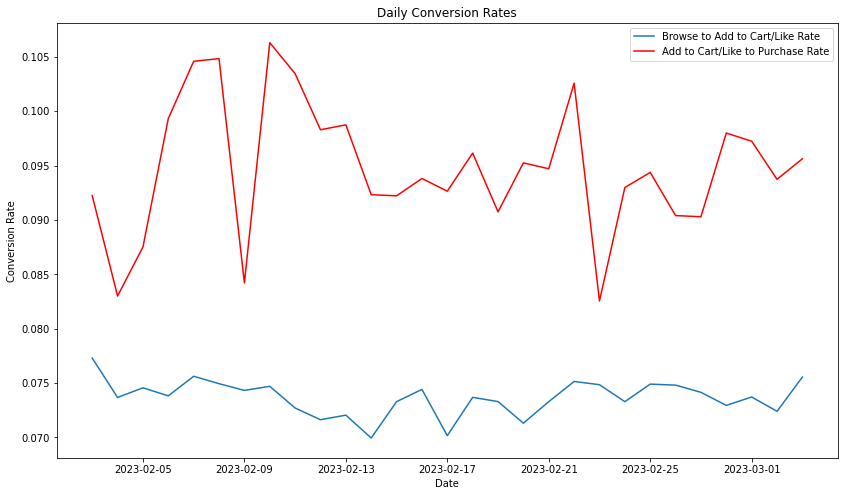

In [72]:
# Combine 'is_like' and 'is_addcart' into a new column 'is_like_or_addcart'
user_data['is_like_or_addcart'] = user_data['is_like'] | user_data['is_addcart']

# Calculate the "Browse to Add to Cart/Like" and "Add to Cart/Like to Purchase" conversion rates for each user
user_conversion_rates = user_data.groupby('user_id').sum()
user_conversion_rates['browse_to_like_or_addcart_rate'] = user_conversion_rates['is_like_or_addcart'] / user_conversion_rates['is_clk']
user_conversion_rates['like_or_addcart_to_order_rate'] = user_conversion_rates['is_order'] / user_conversion_rates['is_like_or_addcart']

# Calculate the average conversion rates
average_browse_to_like_or_addcart_rate = user_conversion_rates['browse_to_like_or_addcart_rate'].mean()
average_like_or_addcart_to_order_rate = user_conversion_rates['like_or_addcart_to_order_rate'].mean()

# Get all user IDs with above average conversion rates
users_above_average_browse_to_like_or_addcart = user_conversion_rates[user_conversion_rates['browse_to_like_or_addcart_rate'] > average_browse_to_like_or_addcart_rate].index.tolist()
users_above_average_like_or_addcart_to_order = user_conversion_rates[user_conversion_rates['like_or_addcart_to_order_rate'] > average_like_or_addcart_to_order_rate].index.tolist()

# Calculate the daily conversion rates
daily_conversion_rates = user_data.groupby(user_data['expose_start_time'].dt.date).sum()
daily_conversion_rates['daily_browse_to_like_or_addcart_rate'] = daily_conversion_rates['is_like_or_addcart'] / daily_conversion_rates['is_clk']
daily_conversion_rates['daily_like_or_addcart_to_order_rate'] = daily_conversion_rates['is_order'] / daily_conversion_rates['is_like_or_addcart']

# average_browse_to_like_or_addcart_rate, users_above_average_browse_to_like_or_addcart, average_like_or_addcart_to_order_rate, users_above_average_like_or_addcart_to_order, daily_conversion_rates[['daily_browse_to_like_or_addcart_rate', 'daily_like_or_addcart_to_order_rate']]

# Filter the DataFrame to include only the users with above average conversion rates
above_average_conversion_users_browse_to_like_or_addcart = user_data[user_data['user_id'].isin(users_above_average_browse_to_like_or_addcart)]
above_average_conversion_users_like_or_addcart_to_order = user_data[user_data['user_id'].isin(users_above_average_like_or_addcart_to_order)]

# Save these filtered DataFrames to new CSV files
above_average_conversion_users_browse_to_like_or_addcart.to_csv('above_average_conversion_users_browse_to_like_or_addcart.csv', header=True)
above_average_conversion_users_like_or_addcart_to_order.to_csv('above_average_conversion_users_like_or_addcart_to_order.csv', header=True)

# Plot the daily conversion rates
fig, ax = plt.subplots(figsize=(14, 8))

daily_conversion_rates['daily_browse_to_like_or_addcart_rate'].plot(kind='line', ax=ax, label='Browse to Add to Cart/Like Rate')
daily_conversion_rates['daily_like_or_addcart_to_order_rate'].plot(kind='line', ax=ax, color='red', label='Add to Cart/Like to Purchase Rate')

plt.title('Daily Conversion Rates')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend(loc='best')

plt.show()

## Part2 时间规律

### 1.1 用户行为频次(日分布)
理论上来说，在不同时间尺度下，商品销售存在周期性，但由于只有一个月的数据，而且只记录了首次曝光时间，所以在本数据集，没有观察到明确的规律。
这是用户行为的时间轴统计。

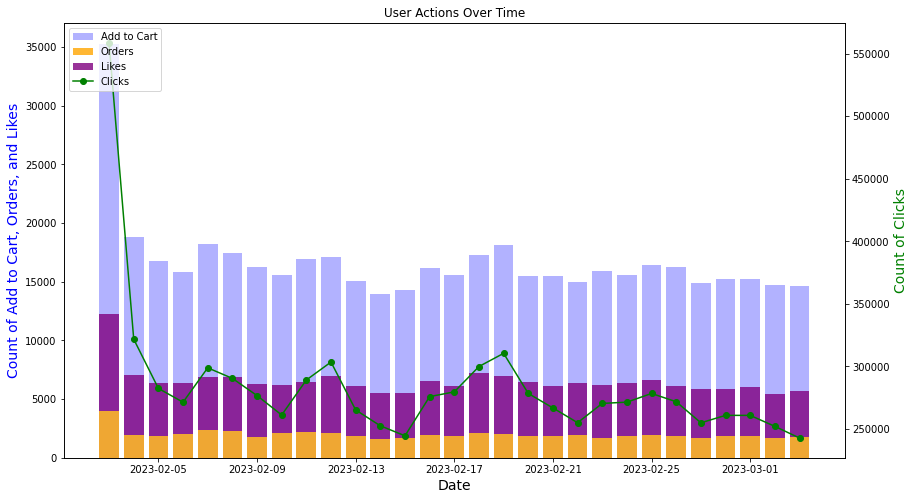

In [73]:
# Group by 'date' and calculate the sum for each day
daily_data = user_data.groupby(user_data['expose_start_time'].dt.date).sum()

# Create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(14, 8))

# Make a plot with column 'is_addcart', 'is_order' and 'is_like' with ax as parameter, setting the label for legend and color
ax.bar(daily_data.index, daily_data['is_addcart'], label='Add to Cart', color='blue', alpha=0.3)
ax.bar(daily_data.index, daily_data['is_order'], label='Orders', color='orange', alpha=0.8)
ax.bar(daily_data.index, daily_data['is_like'], label='Likes', color='purple', alpha=0.8, bottom=daily_data['is_order'])

# Set x-axis label
ax.set_xlabel("Date", fontsize=14)

# Set y-axis label
ax.set_ylabel("Count of Add to Cart, Orders, and Likes", color="blue", fontsize=14)

# Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

# Make a plot with different y-axis using second axis object
ax2.plot(daily_data.index, daily_data['is_clk'], label='Clicks', color='green', marker='o')

# Set y-axis label
ax2.set_ylabel("Count of Clicks", color="green", fontsize=14)

# Setting the title
plt.title('User Actions Over Time')

# Adding the legend
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

plt.show()

### 1.2 用户行为频次(小时分布)

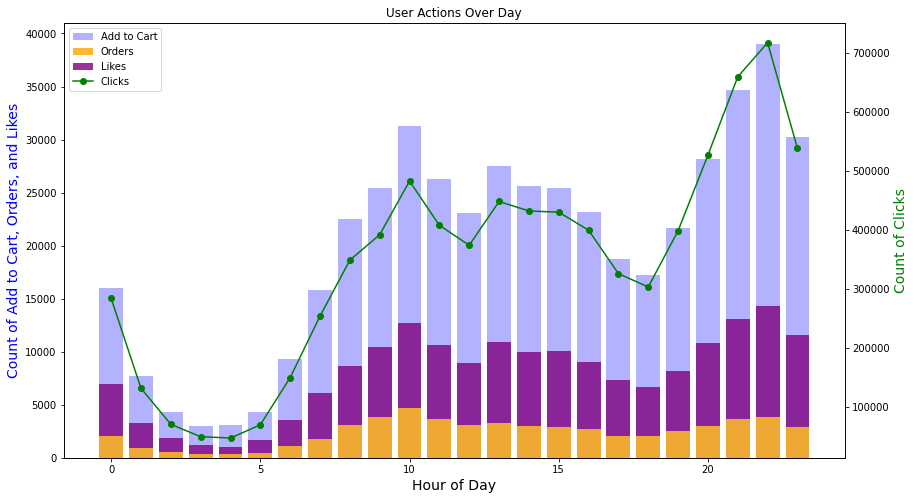

In [74]:
# Create a new column 'hour_of_day' with the hour of the day
user_data['hour_of_day'] = user_data['expose_start_time'].dt.hour

# Group by 'hour_of_day' and calculate the sum for each hour
hourly_data = user_data.groupby('hour_of_day').sum()

# Initialize the hours of day in correct order
hours_ordered = list(range(24))

# Create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(14, 8))

# Make a plot with column 'is_addcart', 'is_order' and 'is_like' with ax as parameter, setting the label for legend and color
ax.bar(hours_ordered, hourly_data['is_addcart'], label='Add to Cart', color='blue', alpha=0.3)
ax.bar(hours_ordered, hourly_data['is_order'], label='Orders', color='orange', alpha=0.8)
ax.bar(hours_ordered, hourly_data['is_like'], label='Likes', color='purple', alpha=0.8, bottom=hourly_data['is_order'])

# Set x-axis label
ax.set_xlabel("Hour of Day", fontsize=14)

# Set y-axis label
ax.set_ylabel("Count of Add to Cart, Orders, and Likes", color="blue", fontsize=14)

# Twin object for two different y-axis on the sample plot
ax2 = ax.twinx()

# Make a plot with different y-axis using second axis object
ax2.plot(hours_ordered, hourly_data['is_clk'], label='Clicks', color='green', marker='o')

# Set y-axis label
ax2.set_ylabel("Count of Clicks", color="green", fontsize=14)

# Setting the title
plt.title('User Actions Over Day')

# Adding the legend
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

plt.show()